# Data Analysis for Software Engineers

## Practical Assignment 4
## Linear classification

Take into account that some tasks may not have a rigorous and comprehensive solution.

Support your code with comments and illustrations if needed. The more conclusions, derivations and explanations you provide - the better.

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

## (Stochastic) Gradient Descent

Consider the logistic regression method for binary classification. 

In this part, you need to implement the following algorithms for log-loss optimization
* gradient descent (GD) 
* stochastic gradient descent (SGD)

In these three methods a gradient of a loss function $L(w) = \frac{1}{N}\sum_i^N l_i(w)$ is obtained differently:

* In GD the whole training dataset is used: $\nabla_wL(w) = \nabla_w\frac{1}{N}\sum_i l_i(w)$

* In SGD only one random training object $i$ is used for gradient estimation: $\nabla_wL(w) \approx \nabla_w l_i(w)$. So one **epoch** in SGD proceeds as follows:
    * Shuffle training dataset
    * Iterate over dataset objects one by one

## Elastic Net Loss (1 point)

Consider logistic regression with $L_1$ and $L_2$ regularization - elastic net.

$$
L(w, w_0) = \frac{1}{N} \sum_i^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2
$$

Find its gradient and update rules for gradient descent:

Your answer with LaTex:

$$
\nabla_wL(w, w_0) = \frac{1}{N} \sum_i^N \frac{-y_i x_i \exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))}  + \gamma sign(w) + 2 \beta w
$$

$$
\nabla_{w_0}L(w, w_0) = \frac{1}{N} \sum_i^N \frac{-y_i \exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))}
$$

Implement corresponding python function

In [33]:
def get_grad(X, y, coef, intercept, gamma=1., beta=1.):
    # grad_coef is a 1-dim array; grad_intercept is a float number
    grad_coef = (-y*np.exp(-y*(X @ coef + intercept)) / (1 + np.exp(-y*(X @ coef+ intercept))))
    grad_intercept = np.mean(grad_coef)
    grad_coef = np.mean(X.T * grad_coef, axis = 1)
    grad_coef += gamma * np.sign(coef)  + 2 * beta * coef 
    
    return grad_coef, grad_intercept

In [241]:
# Here you can test your grad computation (comare your exact computation with numerical approximation)

def loss(X, y, coef, intercept, gamma=1., beta=1.):
    return np.log(1+np.exp(-y*(X @ coef+ intercept))).mean() + gamma * np.linalg.norm(coef, ord=1) + beta * (np.linalg.norm(coef, ord=2) ** 2)

def get_grad_numerical(X, y, coef, intercept, gamma=1., beta=1., eps=0.000001):
    mean_grad_coef = []
    for i, _ in enumerate(coef):
        coef_ = coef.copy()
        coef_[i]+=eps
        mean_grad_coef.append((loss(X, y, coef_, intercept, gamma=1., beta=1.) - loss(X, y, coef, intercept, gamma=1., beta=1.))/eps)
        
    intercept_ = intercept+eps
    mean_grad_intercept = (loss(X, y, coef, intercept_, gamma=1., beta=1.) - loss(X, y, coef, intercept, gamma=1., beta=1.))/eps
    
    return np.array(mean_grad_coef), mean_grad_intercept

np.random.seed(1928)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
y[y==0] = -1
coef, intercept = np.random.normal(size=5), np.random.normal()

grad_coef, grad_intercept = get_grad(X, y, coef, intercept)
grad_coef_numerical, grad_intercept_numerical = get_grad_numerical(X, y, coef, intercept)
print(grad_coef_numerical)
print(grad_intercept_numerical)

assert(np.allclose(grad_coef,
                   grad_coef_numerical,
                   rtol=1e-2) & \
       np.allclose(grad_intercept,
                   grad_intercept_numerical, 
                   rtol=1e-2)
)

[-1.35270935  3.93785444  3.34951486 -1.12671638  3.86531049]
0.4063005727417135


# Algorithm Implementation (3 points)

Some hints:
* Small random numbers from $[−1/2d,1/2d]$ should be chosen for weight initialization. ($d$ - feature space dimension)
* The efficient step size for GD is approximately $0.01 − 1$.
* Step size should be constant for GD and decreasing for SGD, for example, $\alpha/\text{epoch_number}$ where $\alpha$ is some constant
*  use [`sklearn.utils.shuffle`](http://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html) to shuffle `X` and `y` in a consistent way
* Stopping criteria: for GD use $|L_{old} − L_{new}| < tol$, for SGD simply do a particular number of iterations.
* For code efficiency use numpy vectors to compute gradients

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [743]:
# Class for simple gradient descent
class MyVanillaGD(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=0.3, gamma=0.5, tol=0.001, max_epoch=5000, random_state=123, step=0.02):  
        self.beta = beta        
        self.gamma = gamma
        self.tol = tol
        self.max_epoch = max_epoch
        self.random_state = random_state
        self.step = step
        random.seed(random_state)
        
        
    def fit(self, X, y, X_test=None, y_test=None):        
        coef_range = 1 / (2*X.shape[1])
        self.coef_ =  np.array([random.uniform(-coef_range, coef_range) for i in range(X.shape[1])])
        self.intercept_ = random.uniform(-coef_range, coef_range)
        #For printing loss on test dataset
        self.X_test = X_test if type(X_test) is np.ndarray else X
        self.y_test = y_test if type(X_test) is np.ndarray else y
        return self.grad_descent(X, y, self.step)
    
    
    def predict(self, X): 
        predict = (self.predict_proba(X)[:] > 0.5).astype(int)
        return predict
    
    
    def predict_proba(self, X):
        return 1 / (1 + np.exp(-X @ self.coef_ - self.intercept_))
    
    
    def loss(self, X, y):
        return np.log(1 + np.exp(-y*(X @ self.coef_+ self.intercept_))).mean() + self.gamma * np.linalg.norm(self.coef_, ord=1) + self.beta * (np.linalg.norm(self.coef_, ord=2) ** 2)
    
    
    def grad_descent(self, X, y, eta):
        stats = []
        self.test_stats = []
        self.old_loss = self.loss(X, y)
        for _ in range(self.max_epoch):
            # Calculate gradient
            grad_coef, grad_intercept = get_grad(X, y, self.coef_, self.intercept_, gamma=self.gamma, beta=self.beta)
            self.coef_ -= eta*grad_coef
            self.intercept_ -= eta*grad_intercept
            # Save stats on test dataset
            self.test_stats.append(self.loss(self.X_test, self.y_test))
            # Early stopping
            current_loss = self.loss(X, y)
            stats.append(current_loss)
            if np.abs(current_loss - self.old_loss) < self.tol:
                return stats
            self.old_loss = current_loss
            
        return stats
    
    
    def get_test_stats(self):
        return self.test_stats
    
    
    def get_coef(self):
        return self.coef_

            
# Class for SGD
class MySGD(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=0.3, gamma=0.5, max_epoch=200, random_state=123, a=1, treshhold=0.5):
        self.beta = beta        
        self.gamma = gamma
        self.max_epoch = max_epoch
        self.random_state = random_state
        self.step = a
        self.treshhold = treshhold
        random.seed(random_state)
        np.random.seed(random_state)
        
    
    def fit(self, X, y):
        y[y == 0] = -1
        coef_range = 1 / (2*X.shape[1])
        self.coef_ = np.array([random.uniform(-coef_range, coef_range) for i in range(X.shape[1])])
        self.intercept_ = random.uniform(-coef_range, coef_range)
        return self.grad_descent(X, y)
        
    
    def predict(self, X):
        predict = (self.predict_proba(X)[:] > self.treshhold).astype(int)
        return predict
        
        
    def predict_proba(self, X):
        return 1 / (1 + np.exp(-X @ self.coef_ - self.intercept_))
    
    
    def loss(self, X, y):
        return np.log(1 + np.exp(-y*(X @ self.coef_+ self.intercept_))).mean() + self.gamma * np.linalg.norm(self.coef_, ord=1) + self.beta * (np.linalg.norm(self.coef_, ord=2) ** 2)
    
    
    def grad_descent(self, X, y):
        stats = []
        positions = [i for i in range(len(X) - 1)]
        for j in range(self.max_epoch):
            np.random.shuffle(positions)
            eta = self.step / (j + 1) 
            for i in positions:
                #calculate gradient
                grad_coef, grad_intercept = get_grad(np.array([X[i]]), np.array([y[i]]), self.coef_, self.intercept_, gamma=self.gamma, beta=self.beta)
                self.coef_ -= eta*grad_coef
                self.intercept_ -= eta*grad_intercept
            stats.append(self.loss(X, y))
            
        return stats

# Checking on simple datasets (1 point)

Let's check your models on a toy dataset. Don’t forget to standardize the data and then add a constant feature to it. Use the same random state for GD and SGD

Here you should demonstrate the following plots:
* data points and decision boundary for each method,
* $L(w)$ as a function of epoch number (for both GD and SGD).

In [744]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

RND_SEED = 123

In [745]:
def get_toy_dataset():
    return make_classification(n_samples=1000, n_features=2, class_sep=0.5, 
                               n_clusters_per_class=1, n_redundant=0, 
                               shift=4, scale=2, random_state=RND_SEED)

def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 500),
                         np.linspace(X2min, X2max, 500))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)
    
X, y = get_toy_dataset()
scaler = StandardScaler()
X = scaler.fit_transform(X)
y[y == 0] = -1

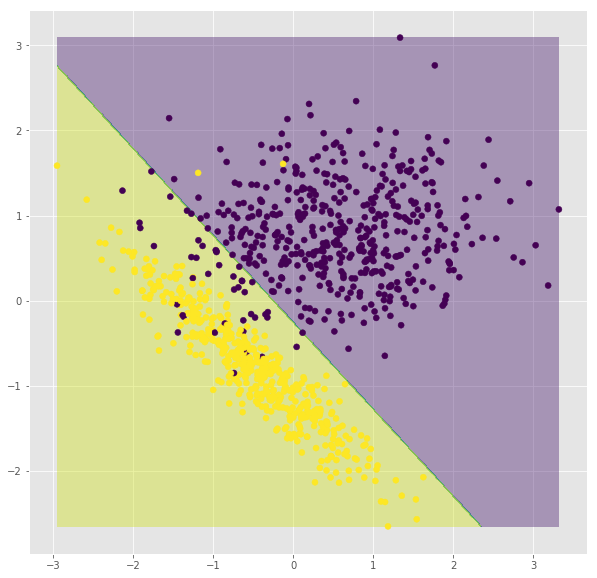

In [755]:
gd = MyVanillaGD(beta=0.3, gamma=0.5, tol=0.005, max_epoch=5000)
gd_stats = gd.fit(X, y)
plot_decision_boundary(gd, X, y)

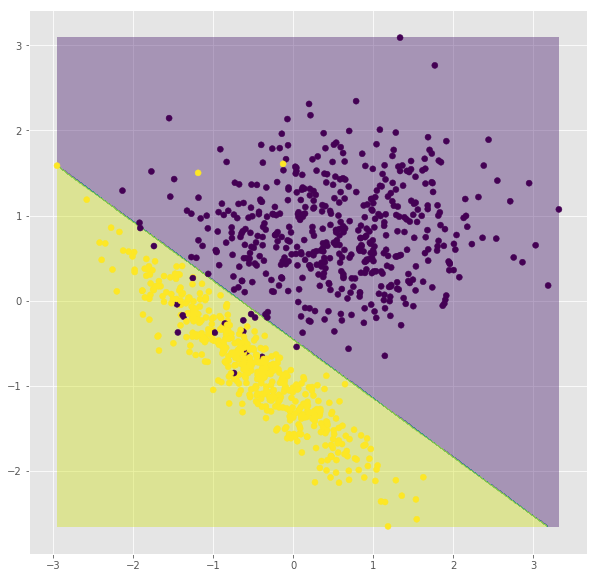

In [753]:
sgd = MySGD(beta=0.0, gamma=0.0, max_epoch=50)
sgd_stats = sgd.fit(X, y)
plot_decision_boundary(sgd, X, y)

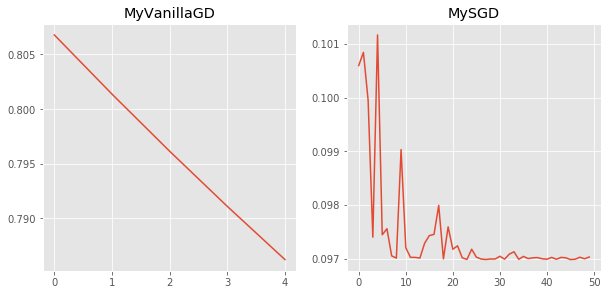

In [756]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.title.set_text('MyVanillaGD')
ax2.title.set_text('MySGD')
ax1.plot(gd_stats)
ax2.plot(sgd_stats)
plt.show()

# Regulatization (2 points)

#### Task 1

* Load the dataset from 'audit' folder. Fit a logistic regression classifier on the training samples. Use GD with different regularizations (without one, only L1, only L2, L1 and L2), use the same random state for all runs. Don’t forget to standardize the data (for example use StandardScaler from sklearn.preprocessing) and then add a constant feature to it.
* split data on train and test, using train_test_split from sklearn with test_size = 0.3 (don't forget set random_state)
* Plot loss on test data_set wrt to epoch number

In [757]:
data = pd.read_csv("./audit_data/audit_risk.csv")
data.head()

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,...,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
0,3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5.0,...,0.4,0,0.2,0.0,2.4,8.574,0.4,0.5,1.7148,1
1,3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5.0,...,0.4,0,0.2,0.0,2.0,2.554,0.4,0.5,0.5108,0
2,3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5.0,...,0.4,0,0.2,0.0,2.0,1.548,0.4,0.5,0.3096,0
3,3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,...,0.4,0,0.2,0.0,4.4,17.530,0.4,0.5,3.5060,1
4,3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,...,0.4,0,0.2,0.0,2.0,1.416,0.4,0.5,0.2832,0


In [758]:
X, y = data[data.columns[:-1]], data[data.columns[-1]]
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = np.array(y.replace(0, -1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RND_SEED)
y_test[y_test == -1] = 0

/home/tema/Programs/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/tema/Programs/anaconda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [759]:
simple_gd = MyVanillaGD(beta=0, gamma=0, tol=1e-5, max_epoch=10000, step=0.01)
simple_gd.fit(X_train, y_train, X_test, y_test)
simple_gd_stats = simple_gd.get_test_stats()
predictions = simple_gd.predict(X_test)
print("accuracy: {}".format(accuracy_score(y_test, predictions)))
print("roc_auc_score: {}".format(roc_auc_score(y_test, predictions)))

accuracy: 0.9613733905579399
roc_auc_score: 0.9595786963434022


In [770]:
l1_gd = MyVanillaGD(beta=0, gamma=0.05, tol=0.00005, max_epoch=800, step=0.001)
l1_gd.fit(X_train, y_train, X_test, y_test)
l1_gd_stats = l1_gd.get_test_stats()
predictions = l1_gd.predict(X_test)
print("accuracy: {}".format(accuracy_score(y_test, predictions)))
print("roc_auc_score: {}".format(roc_auc_score(y_test, predictions)))

accuracy: 0.9484978540772532
roc_auc_score: 0.9344197138314785


In [761]:
l2_gd = MyVanillaGD(beta=0.02, gamma=0, tol=0.00001, max_epoch=50000, step=0.001)
l2_gd.fit(X_train, y_train, X_test, y_test)
l2_gd_stats = l2_gd.get_test_stats()
predictions = l2_gd.predict(X_test)
print("accuracy: {}".format(accuracy_score(y_test, predictions)))
print("roc_auc_score: {}".format(roc_auc_score(y_test, predictions)))

accuracy: 0.9613733905579399
roc_auc_score: 0.9520667726550079


In [780]:
l12_gd = MyVanillaGD(beta=0.01, gamma=0.03, tol=0.00001, max_epoch=1100, step=0.001)
l12_gd.fit(X_train, y_train, X_test, y_test)
l12_gd_stats = l12_gd.get_test_stats()
predictions = l12_gd.predict(X_test)
print("accuracy: {}".format(accuracy_score(y_test, predictions)))
print("roc_auc_score: {}".format(roc_auc_score(y_test, predictions)))

accuracy: 0.9484978540772532
roc_auc_score: 0.9344197138314785


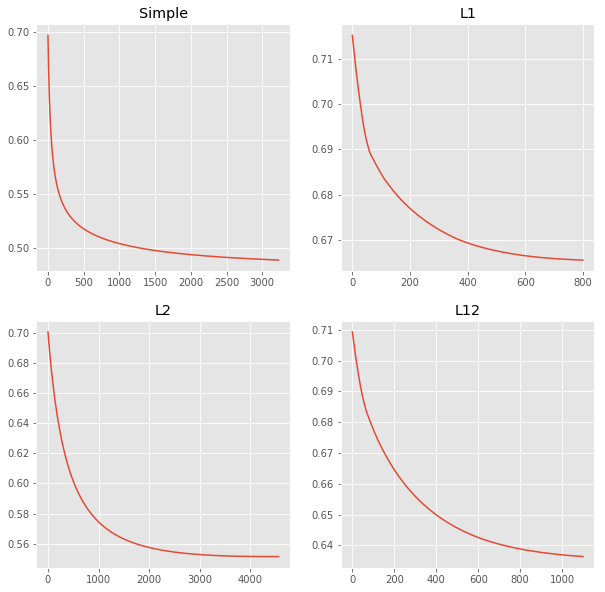

In [781]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (10,10)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.title.set_text('Simple')
ax2.title.set_text('L1')
ax3.title.set_text('L2')
ax4.title.set_text('L12')
ax1.plot(simple_gd_stats)
ax2.plot(l1_gd_stats)
ax3.plot(l2_gd_stats)
ax4.plot(l12_gd_stats)
plt.show()

#### Task 2

* Use the resulting weights vector of GD with L1 regularization to determine two most important features. Fit the logistic classifier only on these two features (+ the constant one) and visualize the decision boundary. Does L1 regularization help you to chose important features?

In [782]:
coefs = l1_gd.get_coef()
intresting_feautures = coefs.argsort()[-2:][::-1]
print(data.columns[intresting_feautures])

Index(['Score', 'Score_MV'], dtype='object')


In [783]:
X_little_train = X_train[:,intresting_feautures]
X_little_test = X_test[:,intresting_feautures]

l1_little_gd = MyVanillaGD(beta=0, gamma=0.001, tol=0.00001, max_epoch=10000, step=10)
l1_little_gd.fit(X_little_train, y_train, X_little_test, y_test)
l1_little_gd_stats = l1_gd.get_test_stats()
predictions = l1_little_gd.predict(X_little_test)
print("accuracy: {}".format(accuracy_score(y_test, predictions)))

accuracy: 0.9012875536480687


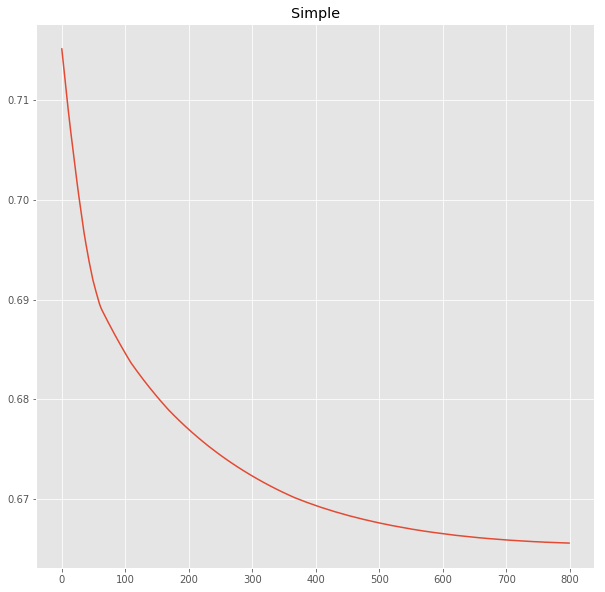

In [784]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (10,10)
ax1 = fig.add_subplot(111)
ax1.title.set_text('Simple')
ax1.plot(l1_little_gd_stats)
plt.show()

#### Task 3

* Provide visual demonstration, that your regularization works. For each feature plot its weight wrt to regularization coefficients

 * $\beta = 0$, $\gamma \in [10^{-4}, 10^4]$
 * $\beta \in [10^{-4}, 10^4]$, $\gamma = 0$
 * $\beta \in [10^{-4}, 10^4]$, $\gamma = 0.2 \cdot \beta$

Your plots should look similar to
<img src="https://github.com/shestakoff/hse_se_ml/blob/master/2020/s05-logistic-regresion/img/example.png?raw=1" />

No handles with labels found to put in legend.


Text(0, 0.5, 'Features')

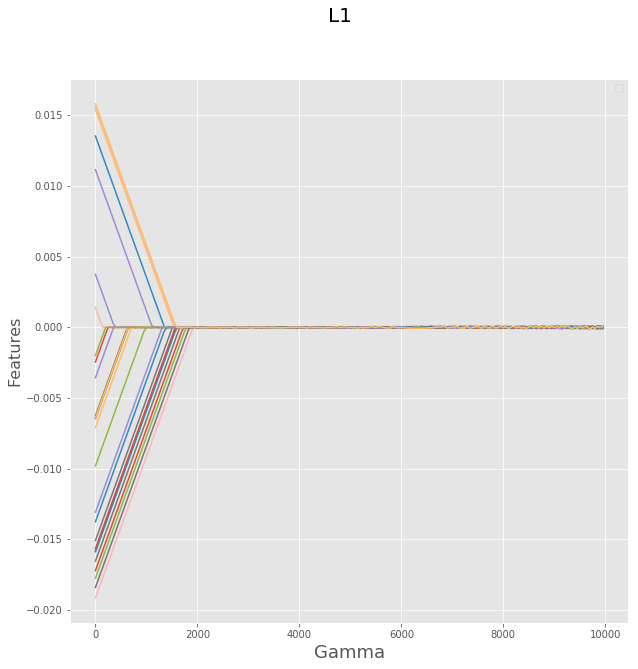

In [796]:
coefs = []
gammas =[]
for i in range(1, 100000001, 500000):
    gamma = i / 10000
    gammas.append(gamma)
    simple_gd = MyVanillaGD(beta=0, gamma=gamma, max_epoch=1000, step=0.00000001, tol=1e-10)
    simple_gd.fit(X_train, y_train, X_test, y_test)
    simple_gd_stats = simple_gd.get_test_stats()
    coefs.append(simple_gd.get_coef())

fig = plt.figure()
coefs = np.stack(np.array(coefs))
for i in range(len(data.columns) - 1):
    plt.plot(gammas , coefs[:,i])
plt.legend()
fig.suptitle('L1', fontsize=20)
plt.xlabel('Gamma', fontsize=18)
plt.ylabel('Features', fontsize=16)

No handles with labels found to put in legend.


Text(0, 0.5, 'Features')

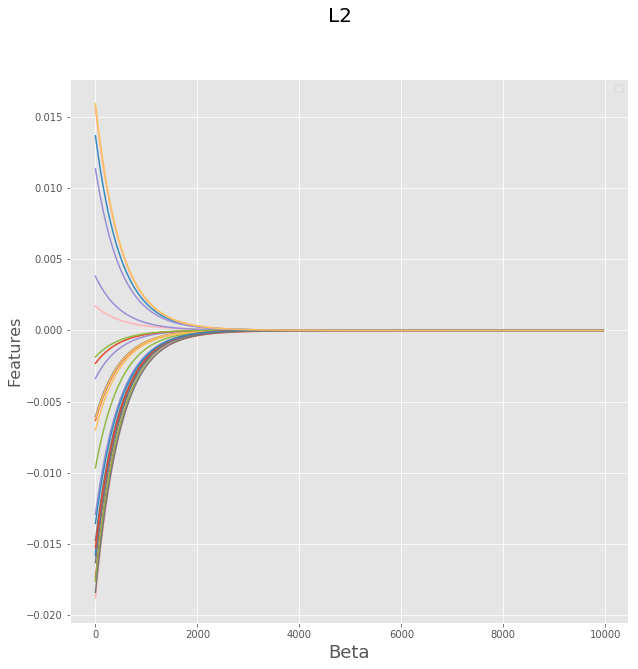

In [799]:
coefs = []
betas =[]
for i in range(1, 100000001, 500000):
    beta = i / 10000
    betas.append(beta)
    simple_gd = MyVanillaGD(gamma=0, beta=beta, max_epoch=1000, step=0.000001, tol=1e-10)
    simple_gd.fit(X_train, y_train, X_test, y_test)
    simple_gd_stats = simple_gd.get_test_stats()
    coefs.append(simple_gd.get_coef())

fig = plt.figure()
coefs = np.stack(np.array(coefs))
for i in range(len(data.columns) - 1):
    plt.plot(betas , coefs[:,i])
plt.legend()
fig.suptitle('L2', fontsize=20)
plt.xlabel('Beta', fontsize=18)
plt.ylabel('Features', fontsize=16)

No handles with labels found to put in legend.


Text(0, 0.5, 'Features')

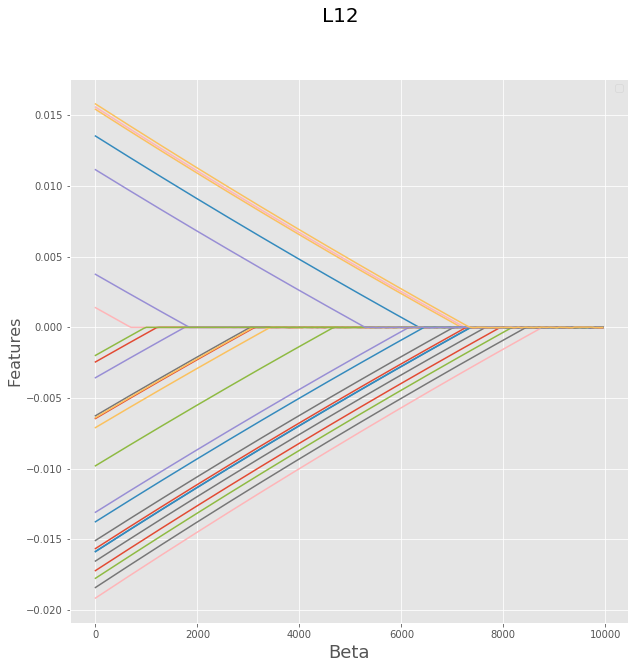

In [801]:
coefs = []
betas =[]
for i in range(1, 100000001, 500000):
    beta = i / 10000
    betas.append(beta)
    simple_gd = MyVanillaGD(gamma=0.2*beta, beta=beta, tol=1e-10, max_epoch=1000, step=0.00000001)
    simple_gd.fit(X_train, y_train, X_test, y_test)
    simple_gd_stats = simple_gd.get_test_stats()
    coefs.append(simple_gd.get_coef())

fig = plt.figure()
coefs = np.stack(np.array(coefs))
for i in range(len(data.columns) - 1):
    plt.plot(betas , coefs[:,i])
plt.legend()
fig.suptitle('L12', fontsize=20)
plt.xlabel('Beta', fontsize=18)
plt.ylabel('Features', fontsize=16)

# Real Dataset (3 points)

In this part of the task you will work with the problem of diabetes diagnostics. Load the diabetes dataset using pickle.load.

This dataset has the following features:
1. Number of pregnancies
2. Plasma glucose concentration after 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure
4. Triceps skin fold thickness
5. 2-Hour serum insulin
6. Body mass index
7. Diabetes pedigree function
8. Age

Class label is equal to 1 if a person has a diabetes and to -1 otherwise.

#### Task 1

Train the logistic regression classifier on this dataset. Use SGD without regularization. Don’t
forget to standardize the data and then add a constant feature to it.

In [572]:
import pickle
import seaborn as sns
import pandas as pd

In [573]:
with open('diabetes.pkl', 'rb') as fin:     
    d = pickle.load(fin,encoding='latin')

In [574]:
y = d['labels']
X = d['data']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RND_SEED)

In [575]:
columns = [
    'Number of pregnancies',
    'Plasma glucose concentration after 2 hours in an oral glucose tolerance test',
    'Diastolic blood pressure',
    'Triceps skin fold thickness',
    '2-Hour serum insulin',
    'Body mass index',
    'Diabetes pedigree function',
    'Age'
]
df = pd.DataFrame(X)
df.columns = columns
df['ans'] = y
df.head()

,Number of pregnancies,Plasma glucose concentration after 2 hours in an oral glucose tolerance test,Diastolic blood pressure,Triceps skin fold thickness,2-Hour serum insulin,Body mass index,Diabetes pedigree function,Age,ans
0,0.639947,0.865041,-0.031990,0.670643,0.002728,0.166411,0.468492,1.425995,1
1,-0.844885,-1.206228,-0.528319,-0.012301,0.002728,-0.852411,-0.365061,-0.190672,-1
2,1.233880,2.015746,-0.693761,-0.012301,0.002728,-1.332713,0.604397,-0.105584,1
3,-0.844885,-1.074719,-0.528319,-0.695245,-0.726976,-0.634092,-0.920763,-1.041549,-1
4,-1.141852,0.503391,-2.679076,0.670643,0.143961,1.549099,5.484909,-0.020496,1


/home/tema/Programs/anaconda/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/home/tema/Programs/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/tema/Programs/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


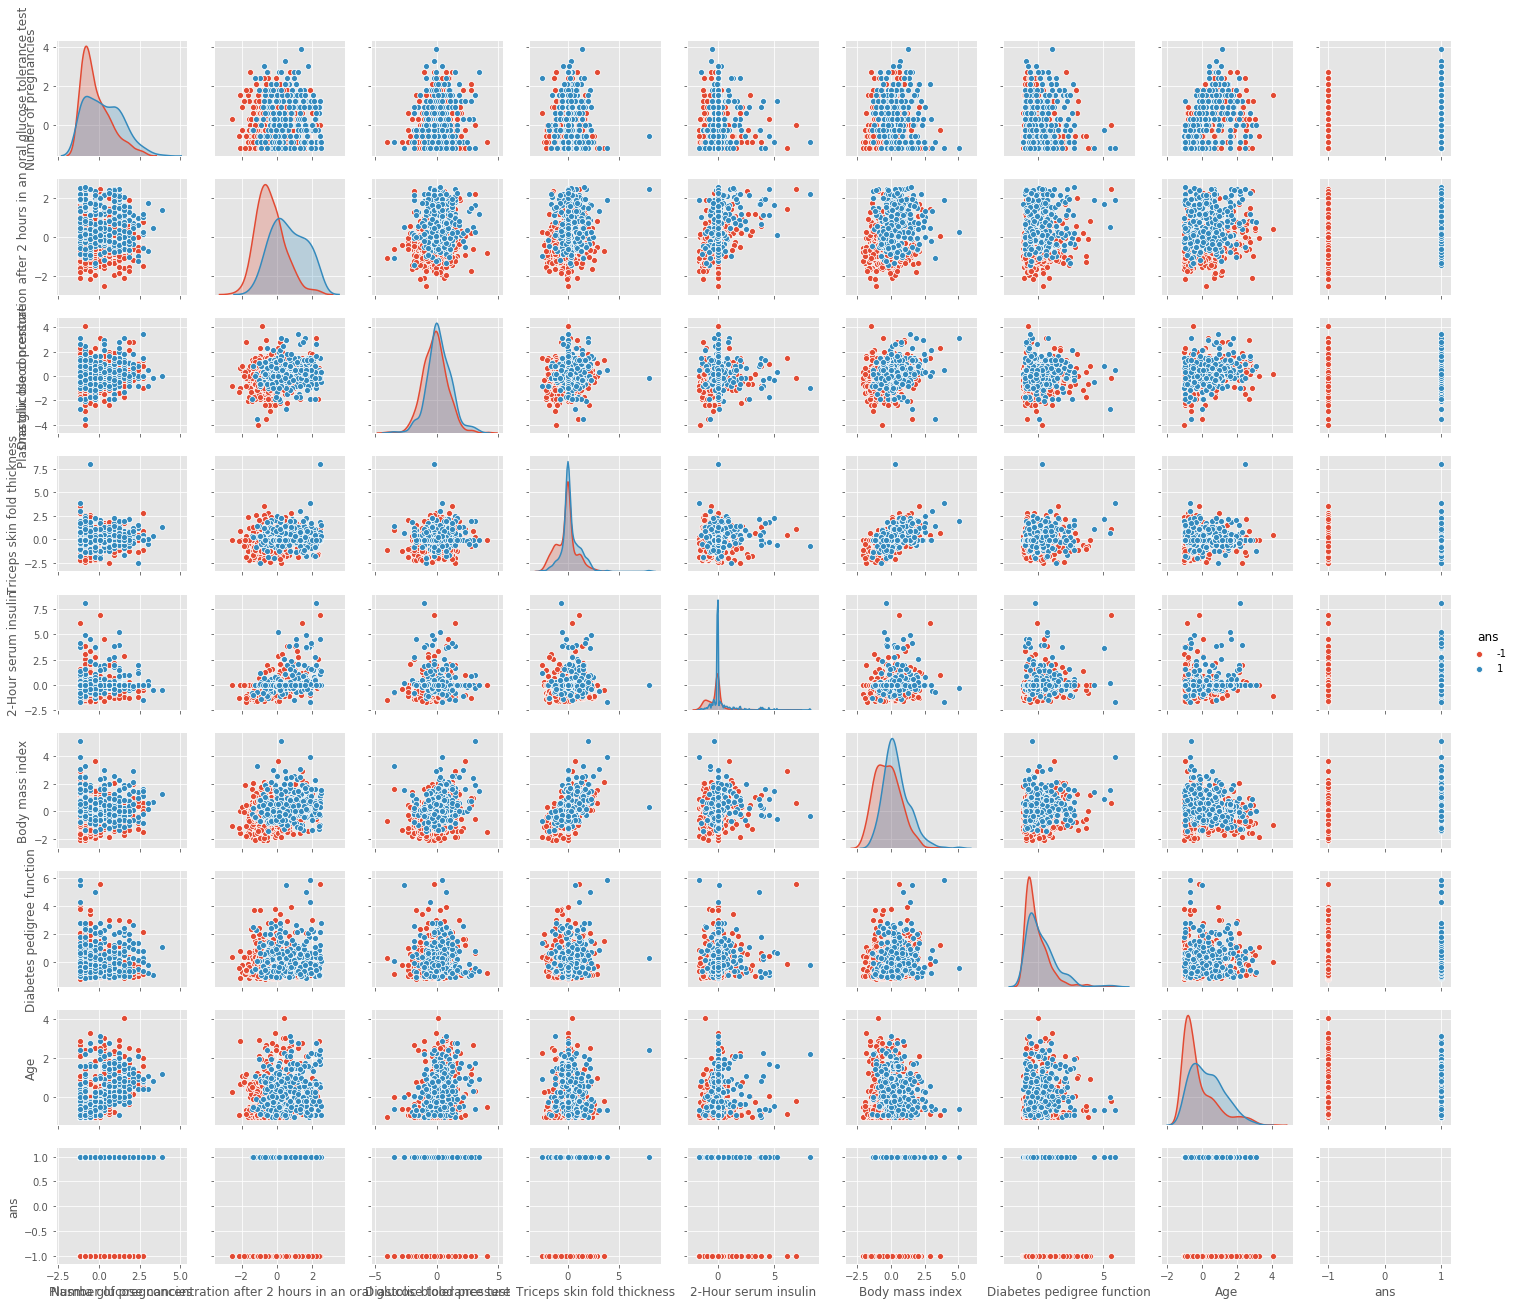

In [576]:
sns.pairplot(df, hue='ans')

In [734]:
sgd = MySGD(beta=0.0, gamma=0.0, max_epoch=1500, a=0.0002)
sgd_stats = sgd.fit(X_train, y_train)

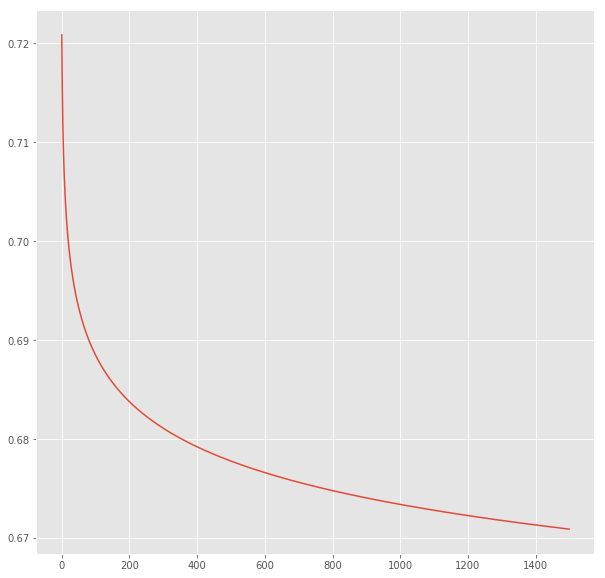

In [735]:
plt.plot(sgd_stats)

In [736]:
predictions = sgd.predict(X_test)
predictions[predictions == 0] = -1
roc_auc_score(y_test, predictions)

0.701923076923077

In [351]:
assert(roc_auc_score(y_test, predictions) > 0.793)

AssertionError: 

#### Task 2

In diagnostic problems, false positive and false negative errors have different costs. 

Let’s say, if we make a false negative error (don’t detect a condition when it is present), then the patient doesn’t have a necessary treatment and, if we make false positive error (detect a condition when it isn’t present), then the patient simply need to be tested more. 

Therefore, the cost of false negative error is higher, and we care much more about this type of error. Compute a confusion matrix for a fitted classifier. 

How many errors of each type have you got? Compute a false positive and false negative rates for this classifier. Why are they so different?

Useful functions: `sklearn.metrics.confusion_matrix`.

In [704]:
from sklearn.metrics import confusion_matrix

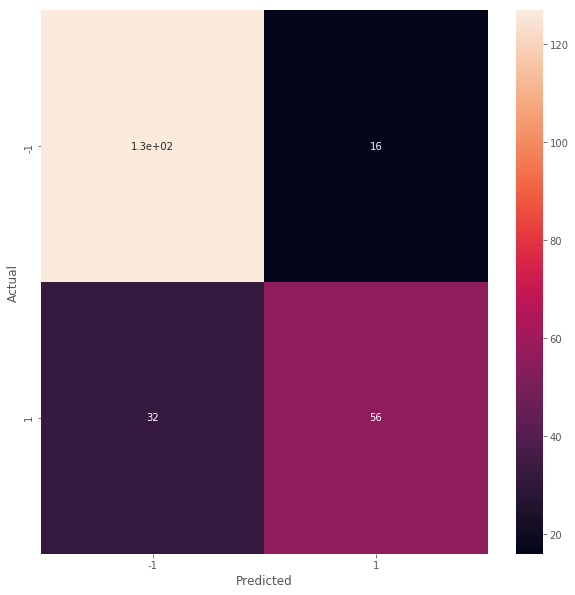

In [705]:
answers = {'y_Actual':y_test, 'y_Predicted': predictions}

df = pd.DataFrame(answers, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

In [706]:
confusion_matrix

Predicted,-1,1
Actual,,
-1,127,16
1,32,56


TN - 127

FN - 32

TP - 56

FP - 16

#### Task 3

To change the proportion of errors of different types you can change a threshold a at the prediction
rule $y = \sigma(w^\top x + w_0) > a$, where $a \in [0, 1]$.

Show the ROC-curve of the fitted classifier and a point on it, which corresponds to $a = 0.5$ (the one you
computed at the previous step). 

Using ROC-curve choose a so that false negative rate is less than $20%$ while a false positive rate is still small. What accuracy and false positive rate does the final algorithm have?

Useful functions: `sklearn.metrics.roc_curve`.

In [713]:
sgd = MySGD(beta=0.0, gamma=0.0, max_epoch=50, a=10, treshhold=0.22)
sgd_stats = sgd.fit(X_train, y_train)
predictions = sgd.predict(X_test)
predictions[predictions == 0] = -1
roc_auc_score(y_test, predictions)

0.7486888111888113

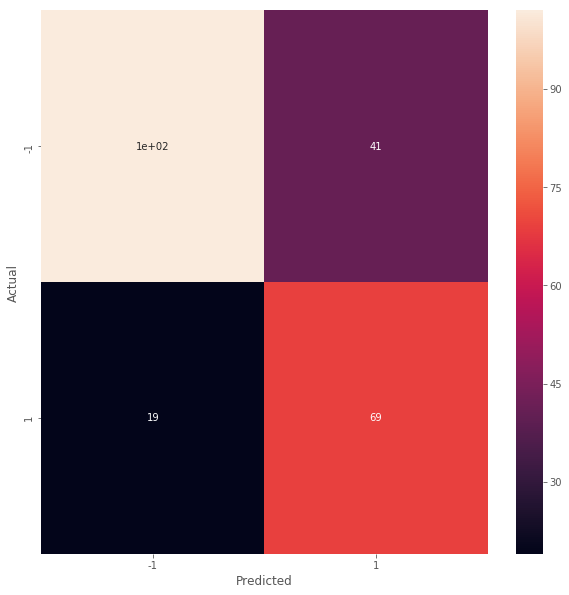

In [714]:
answers = {'y_Actual':y_test, 'y_Predicted': predictions}

df = pd.DataFrame(answers, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

In [715]:
confusion_matrix

Predicted,-1,1
Actual,,
-1,102,41
1,19,69


accuracy = 0.7486888111888113

TN - 102

FN - 19

TP - 69

FP - 41